In [3]:
import Pkg;
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation`


Status `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation/Project.toml`
  [d58978e5] Dagger v0.18.12
  [aaf54ef3] DistributedArrays v0.6.7
  [91a5bcdd] Plots v1.40.5


In [4]:
using Plots

In [5]:
using Distributed

addprocs(4)

4-element Vector{Int64}:
 2
 3
 4
 5

In [6]:
@everywhere begin
    D  = 1e-4
    ds = 1e-4
    dt = ds^2 / D / 8.2
    qx(ix, D, C, ds) = -D * (C[ix+1, 1] - C[ix, 1]) / ds
end

In [7]:
@everywhere using Dagger

In [8]:
# Also: try AutoBlocks()
C = zeros(Blocks(10, 1), 40, 1)

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
~0% completed
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ⋮
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...

In [11]:
C

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [12]:
C[20, 1] = 1/ds

10000.0

In [14]:
C2 = similar(C)

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
~0% completed
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ⋮
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...

In [15]:
C2

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
 6.93402e-310
 6.93402e-310
 6.93402e-310
 6.93402e-310
 6.93402e-310
 6.93402e-310
 6.93402e-310
 6.93402e-310
 6.93402e-310
 6.93402e-310
 2.0e-323
 4.0e-323
 1.5e-323
 ⋮
 1.0e-322
 5.0e-324
 2.0e-323
 4.0e-323
 1.5e-323
 1.6e-322
 2.61194e-314
 4.94e-322
 4.94e-321
 1.235e-321
 1.0e-322
 5.0e-324

In [20]:
myid()

1

In [21]:
d1 = Dagger.@spawn myid()
d2 = Dagger.@spawn myid()

DTask (running)

In [22]:
fetch(d1)

2

In [23]:
fetch(d2)

3

In [24]:
@everywhere function step_diffusion_local!(C2, C)
    proc = myid() - 1
    idx = C.subdomains[proc].indexes[1] # working in 1D
    
    for i in idx
        # absorbing boundary conditions (lo, hi are always set to zero)
        if i==1 || i==size(C, 1)
            continue
        end
        C2[i] = C[i] - dt * (qx(i, D, C, ds) - qx(i-1, D, C, ds)) / ds
    end
end

In [25]:
d = Dagger.@spawn scope=Dagger.scope(worker=2) myid()

DTask (running)

In [26]:
fetch(d)

2

In [30]:
C2 = similar(C)
d = Dagger.@spawn scope=Dagger.scope(worker=3) step_diffusion_local!(C2, C)

DTask (running)

In [36]:
fetch(C2[10:30, 1])

21x1 DMatrix{Float64} with 3x1 partitions of size 10x1:
    6.93403e-310
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
 1219.51
 7560.98
    2.0e-323
    4.0e-323
    1.5e-323
    1.6e-322
    6.93402e-310
    4.94e-322
    4.94e-321
    1.235e-321
    1.0e-322
    6.93403e-310

In [37]:
function step_diffusion(C)
    C2 = similar(C)
    fill!(C2, 0)
    
    dtasks = Dagger.DTask[]
    for w in workers()
        push!(
            dtasks,
            Dagger.@spawn scope=Dagger.scope(worker=w) step_diffusion_local!(C2, C)
        )
    end
    
    # wait for workers
    [fetch(d) for d in dtasks]
    C2
end

step_diffusion (generic function with 1 method)

In [38]:
sols = [Array(C)]
for i in 1:100
    C = step_diffusion(C)
    # Save timesteps. This is super wasteful, don't do this in production
    if i%10 == 0
        push!(sols, Array(C))
    end
end

In [ ]:
# using Plots

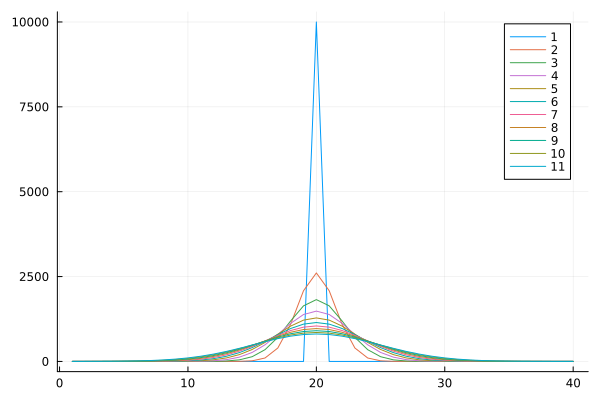

In [39]:
plot()
for (i,c) in enumerate(sols)
    plot!(c, label=i)
end
plot!()

In [40]:
1+1

2